# Waveguide Dispersion

**Scott Prahl**

**Aug 2021**

---
*If* `` ofiber `` *is not installed, uncomment the following cell (i.e., delete the initial #) and execute it with* `` shift-enter ``.  *Afterwards, you may need to restart the kernel/runtime before the module will import successfully.*"

In [1]:
#!pip install --user ofiber

In [2]:
# Jupyterlite support for ofiber
try:
    import micropip
    await micropip.install("ofiber")
except ModuleNotFoundError:
    pass

try:
    import numpy as np
    import matplotlib.pyplot as plt
    import scipy
    import ofiber

except ModuleNotFoundError:
    print('ofiber is not installed. To install, uncomment and run the cell above.')
    print('Once installation is successful, rerun this cell again.')

# to make graphs a bit better
%config InlineBackend.figure_format='retina'
plt.style.use('seaborn-talk')

## Approximating Waveguide Dispersion

Waveguide dispersion $\Delta\tau_w$ is given by equation 10.11 

$$
\Delta\tau_w \approx - \frac{L}{c}n_2\Delta\frac{\Delta\lambda_0}{\lambda_0}\cdot\left(V\frac{d^2(bV)}{dV^2}\right)
$$

which is tough to calculate because of the presence of the normalized propagation factor $b$ which depends on solving the eigenvalue problem for the optical fiber.  However, once this has been done, someone noticed that  could be approximated by

$$
V\frac{d^2(bV)}{dV^2} \approx 0.080+0.549(2.834-V)^2
$$

How good is this approximation?

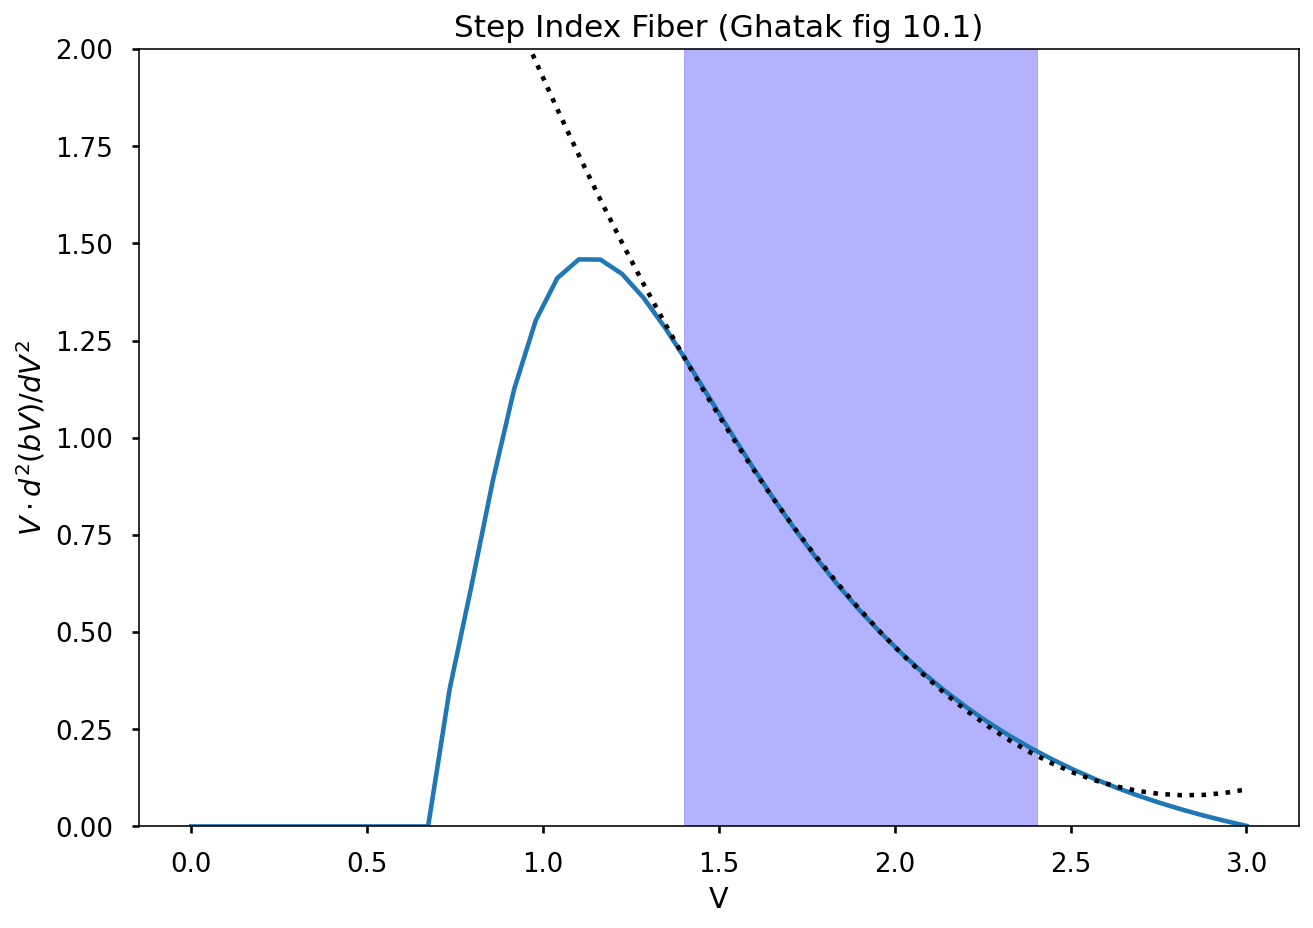

In [3]:
V    = np.linspace(0,3,50)
vbpp = ofiber.V_d2bV_by_V(V,0)
vv   = ofiber.V_d2bV_by_V_Approx(V)
    
plt.plot(V,vbpp)
plt.plot(V,vv,':k')
plt.xlabel('V')
plt.ylabel('$V\cdot d^2(bV)/dV^2$')
plt.title('Step Index Fiber (Ghatak fig 10.1)')
plt.axvspan(1.4, 2.405, color='blue', alpha=0.3)
plt.ylim(0,2)
plt.show()

## Effect of GeO$_2$ on refractive index

Doping the core with GeO$_2$ changes the index of refraction

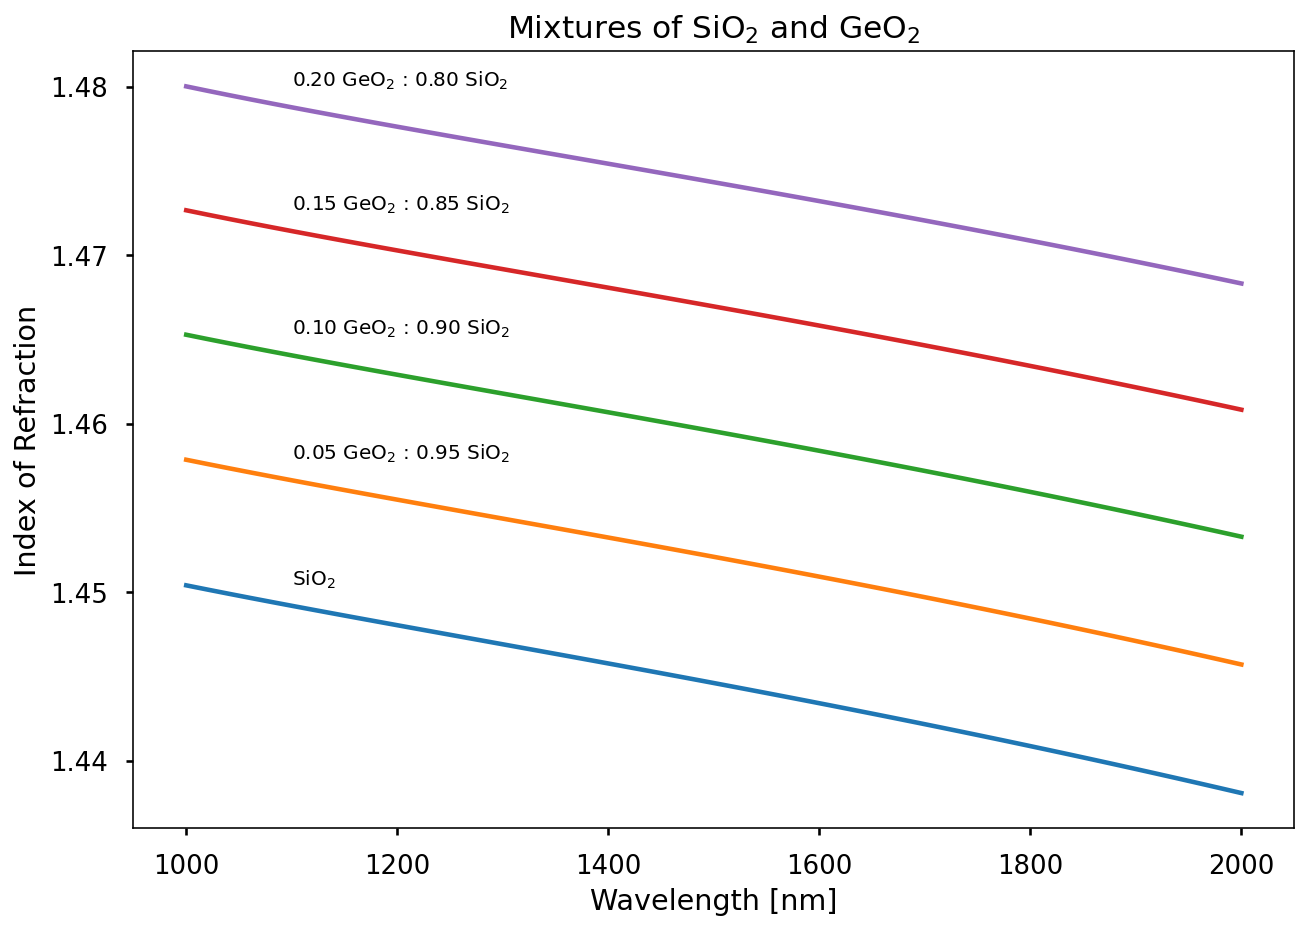

In [4]:
# Doping with GeO2 increases the index of refraction
λ = np.linspace(1.0,2,50)*1e-6

for x in [0,0.05,0.1,0.15,0.2]:
    glass = ofiber.doped_glass(x)
    name  = ofiber.doped_glass_name(x)
    n     = ofiber.n(glass,λ)
    plt.plot(λ*1e9,n)
    plt.annotate(name,xy=(1100,n[0]))

plt.xlabel("Wavelength [nm]")
plt.ylabel("Index of Refraction")
plt.title('Mixtures of SiO$_2$ and GeO$_2$')
plt.show()

## Conventional Single Mode Fiber

CSF has the characteristic that at 1300nm, the total dispersion is near zero.  Following example 10.1, we figure out that the amount of GeO$_2$ doping needed to match the indicies of refraction used in Ghatak's examples is about 2.6%.

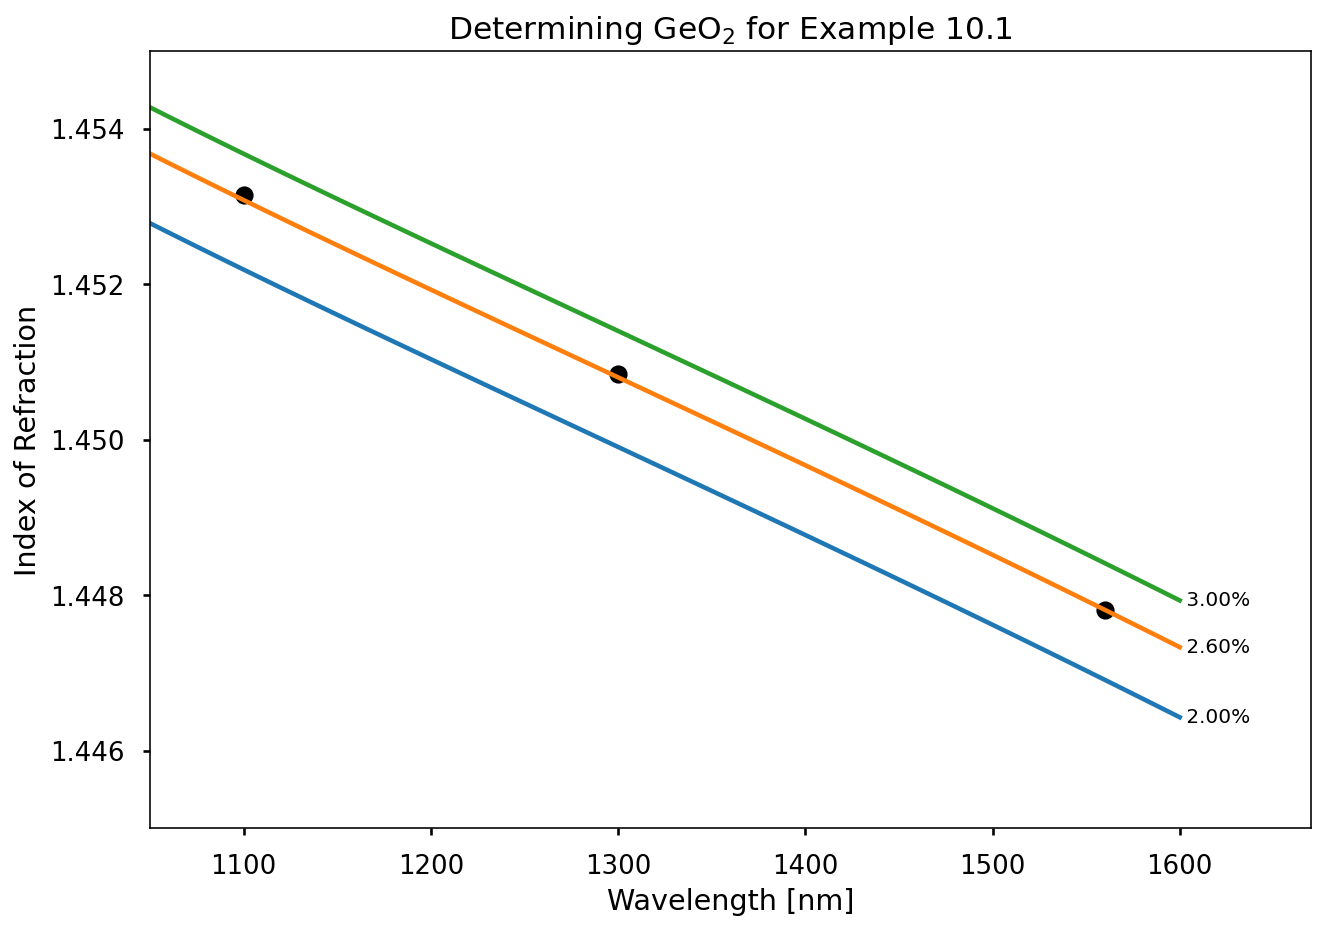

In [5]:
# Ghatak gives the core refractive index at three wavelengths
target  = np.array([1.45315, 1.45084, 1.44781])
λ = np.array([   1100,    1300,    1560]) * 1e-9 # meters

n = ofiber.n(glass,λ)
   
plt.plot(λ*1e9, target, 'ok')

lambdas = np.linspace(1000,1600,50)*1e-9
for x in [0.02,0.0260,0.03]:
    glass = ofiber.doped_glass(x)
    n = ofiber.n(glass,lambdas)
    plt.plot(lambdas*1e9,n)
    plt.text(1600,n[-1], " %.2f%%"%(100*x), va='center')

plt.xlabel('Wavelength [nm]')
plt.ylabel('Index of Refraction')
plt.xlim(1050,1670)
plt.ylim(1.445,1.455)
plt.title('Determining GeO$_2$ for Example 10.1')
plt.show()
   

## General properties of CSF fiber

This reveals that the doping concentration we just obtained is close to the value used by Ghatak.  I adjusted the size of the fiber from 4.1 to 4.12 microns.  The deviations are small and probably due to slightly different index of refraction models for the core

In [6]:
r_core = 4.12e-6                             # m
λ = np.array([1100,1300,1560]) * 1e-9  # m

clad = ofiber.doped_glass(0)
core = ofiber.doped_glass(0.0260) # 2.6% GeO2, 97.4 SiO2

n_clad = ofiber.n(clad, λ)
n_core = ofiber.n(core, λ)

NA = ofiber.numerical_aperture(n_core, n_clad)
V = ofiber.V_parameter(r_core, NA, λ)

vbpp =ofiber.V_d2bV_by_V_Approx(V)
dm, dw = ofiber.Dispersion(core, n_clad, r_core, λ)
dm *= 1e6
dw *= 1e6
dt = dm + dw


print('Ghatak Table 10.2')
print()
print("                  1100nm     1300nm     1560nm")
print("V                 %6.3f     %6.3f     %6.3f"%(V[0],V[1],V[2]))
print("V(bV)''           %6.3f     %6.3f     %6.3f"%(vbpp[0],vbpp[1],vbpp[2]))
print("D_w (ps/km/nm)    %6.2f     %6.2f     %6.2f"%(dw[0],dw[1],dw[2]))
print("D_m (ps/km/nm)    %6.2f     %6.2f     %6.2f"%(dm[0],dm[1],dm[2]))
print("D_t (ps/km/nm)    %6.2f     %6.2f     %6.2f"%(dt[0],dt[1],dt[2]))
print()
print('Small differences probably arise from slightly different index of refraction models for the core')

Ghatak Table 10.2

                  1100nm     1300nm     1560nm
V                  2.497      2.113      1.764
V(bV)''            0.142      0.366      0.709
D_w (ps/km/nm)     -1.77      -3.68      -5.88
D_m (ps/km/nm)    -23.14       1.38      21.45
D_t (ps/km/nm)    -24.91      -2.30      15.58

Small differences probably arise from slightly different index of refraction models for the core


### Contributions of waveguide and material dispersion to total dispersion

Here we see that zero total dispersion is around 1325nm

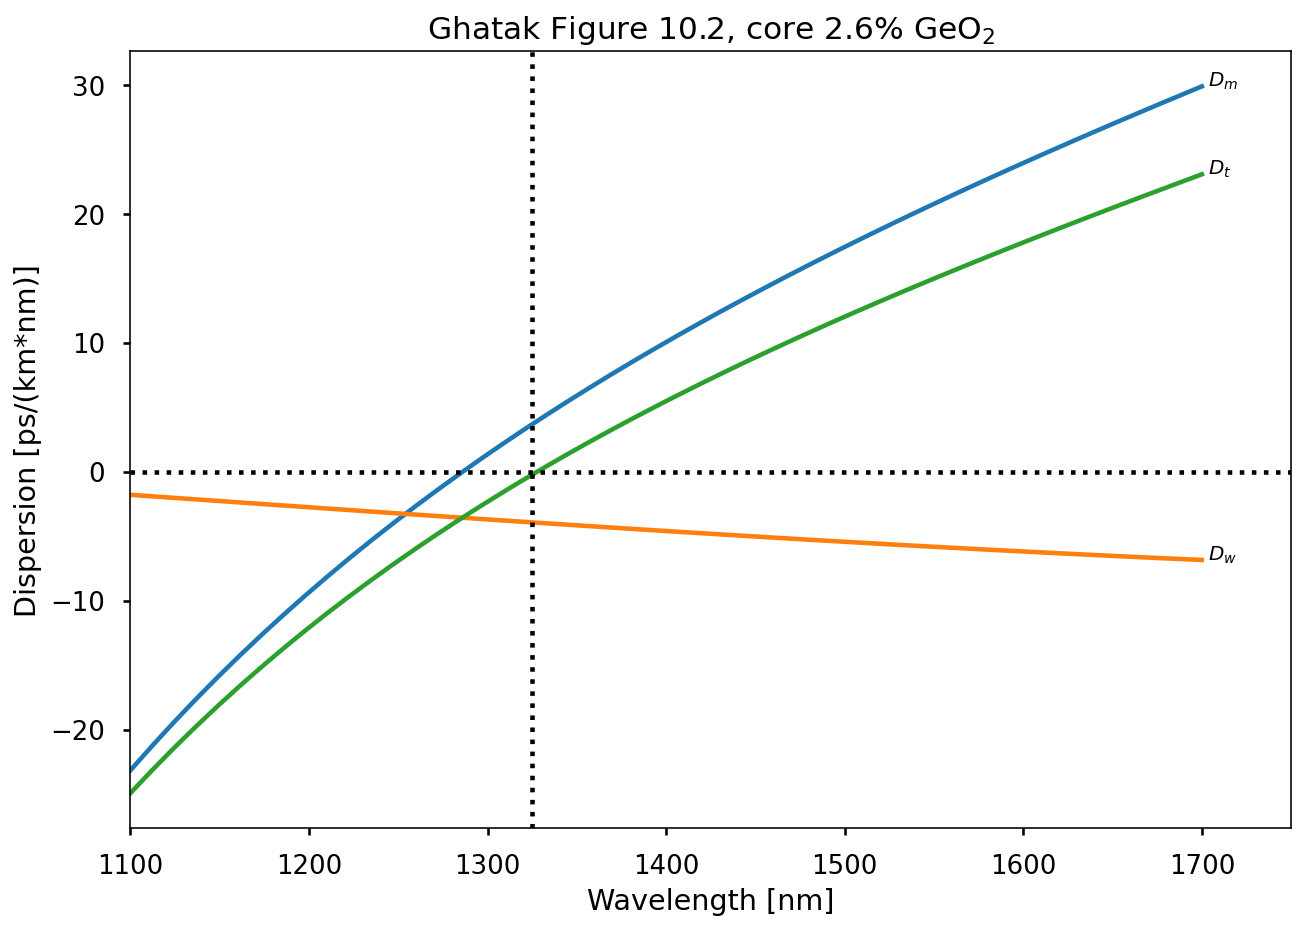

In [7]:
λ = np.linspace(1100,1700,50)*1e-9   # m

n_clad = ofiber.n(clad,λ)
n_core = ofiber.n(core,λ)

dm, dw = ofiber.Dispersion(core, n_clad, r_core, λ)      
dm *= 1e6
dw *= 1e6
dt = dm + dw

plt.plot(λ*1e9,dm)
plt.text(1700, dm[-1], r' $D_m$')
                 
plt.plot(λ*1e9,dw)
plt.text(1700, dw[-1], r' $D_w$')

plt.plot(λ*1e9,dt)
plt.text(1700, dt[-1], r' $D_t$')

plt.axhline(0,   linestyle=':', color='black')
plt.axvline(1325,linestyle=':', color='black')

plt.xlabel("Wavelength [nm]")
plt.ylabel("Dispersion [ps/(km*nm)]")
plt.title('Ghatak Figure 10.2, core 2.6% GeO$_2$')
plt.xlim(1100,1750)
plt.show()

A close-up of the crossing range.

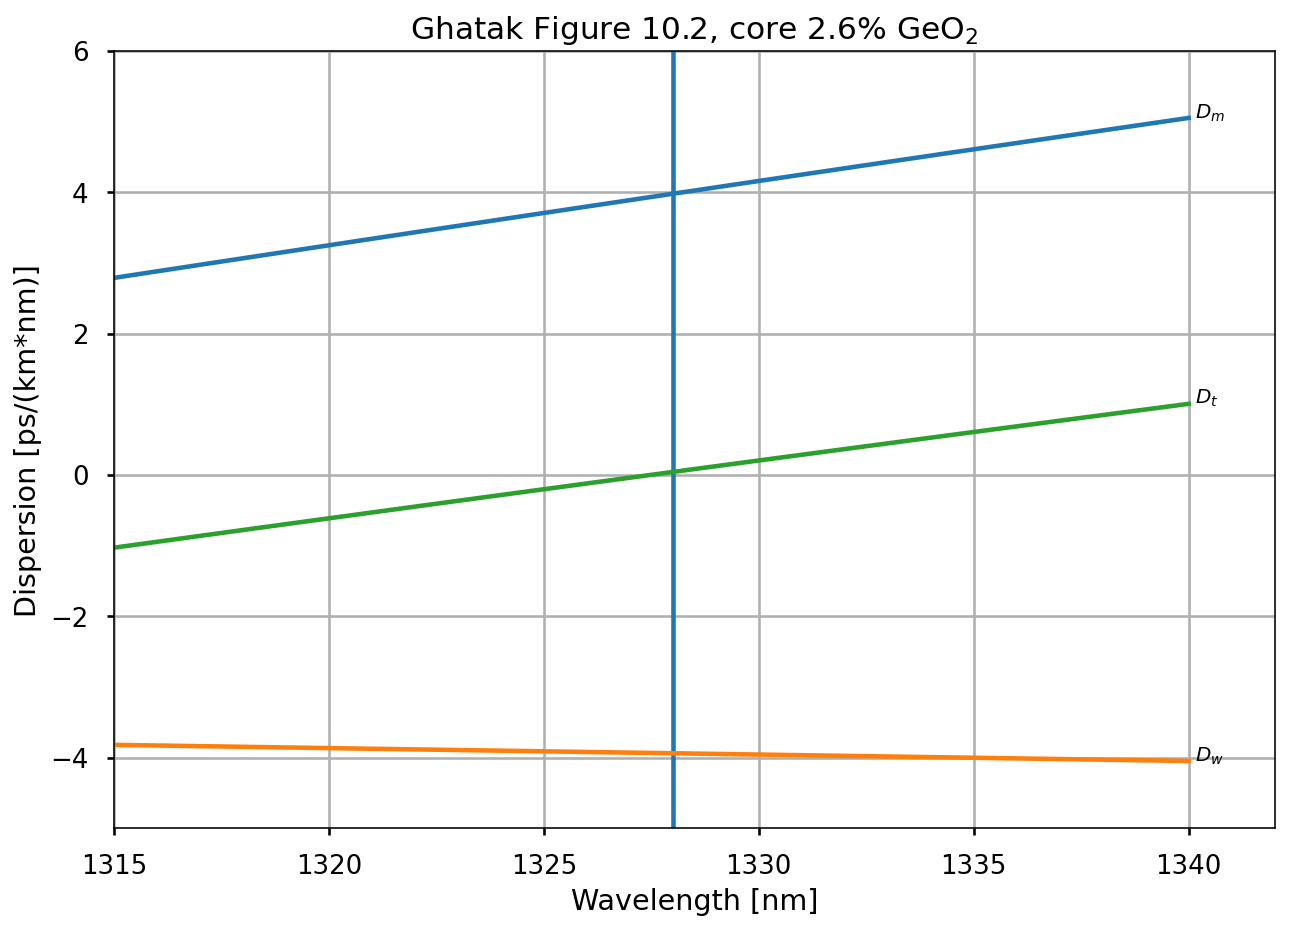

In [8]:
λ = np.linspace(1315,1340,26)*1e-9   # m

n_clad = ofiber.n(clad,λ)
n_core = ofiber.n(core,λ)

dm, dw = ofiber.Dispersion(core, n_clad, r_core, λ)      
dm *= 1e6
dw *= 1e6
dt = dm + dw

izero = 13
plt.axvline(λ[izero]*1e9)

plt.plot(λ*1e9,dm)
plt.text(λ[-1]*1e9, dm[-1], ' $D_m$')

plt.plot(λ*1e9,dw)
plt.text(λ[-1]*1e9, dw[-1], ' $D_w$')

plt.plot(λ*1e9,dt)
plt.text(λ[-1]*1e9, dt[-1], ' $D_t$')

plt.xlabel("Wavelength [nm]")
plt.ylabel("Dispersion [ps/(km*nm)]")
plt.title('Ghatak Figure 10.2, core 2.6% GeO$_2$')
plt.xlim(1315,1342)
plt.ylim(-5,6)
plt.grid(True)
plt.show()

We can figure out the slope at the zero dispersion point.  

In [9]:
slope = (dt[izero+1]-dt[izero])/(λ[izero+1]-λ[izero]) #ps/km/nm * 1/m
slope *= 1e-9                                         #ps/km/nm**2
print('Zero dispersion slope is %.3f ps/(km nm**2)'%slope)

Zero dispersion slope is 0.081 ps/(km nm**2)


## Profile dispersion

First, we replicate the results in Ghatak example 10.2

In [10]:
r_core =4.1e-6                                 # [m]
λ=np.array([1100,1300,1560])*1e-9  # [m]

n_core = ofiber.n(core,λ)
n_clad = ofiber.n(clad,λ)

Delta = (n_core**2-n_clad**2)/(2*n_core**2)
dw = np.empty_like(λ)

for i in range(len(λ)):
    dw[i] = ofiber.Waveguide_Dispersion(n_core[i],n_clad[i],r_core,λ[i])*1e6
    
print("           1100nm     1300nm     1560nm")
print("n_core    %.5f    %.5f    %.5f"%(n_core[0],n_core[1],n_core[2]))
print("n_clad    %.5f    %.5f    %.5f"%(n_clad[0],n_clad[1],n_clad[2]))
print("Delta     %.5f    %.5f    %.5f"%(Delta[0],Delta[1],Delta[2]))
print("D_w         %.2f      %.2f      %.2f"%(dw[0],dw[1],dw[2]))

           1100nm     1300nm     1560nm
n_core    1.45308    1.45080    1.44781
n_clad    1.44920    1.44692    1.44390
Delta     0.00267    0.00267    0.00270
D_w         -1.83      -3.76      -5.96


## Dispersion Shifted Fiber (DSF)

Variation of the material, waveguide, and total dispersion for a step index silica fiber.  Need to increase the GeO₂ doping significantly to get zero dispersion at 1523nm.

First, figure out what wavelength is used for the specified core and cladding indices of refraction.  We assume that the cladding is pure SiO₂

In [11]:
#what wavelength gives r_core cladding index of 1.446918 used in example 10.3
λ = np.linspace(1.1,1.7,601)*1e-6   # m
clad = ofiber.doped_glass(0.00)
n_clad = ofiber.n(clad,λ)

ii=np.argmin(abs(n_clad-1.446918))

print("cladding wavelength is %.1fnm" % (λ[ii]*1e9))

cladding wavelength is 1300.0nm


Well that was not surprising.  It is the same cladding index and wavelength as used in Example 10.2.  Now we want to find the doping for the core.  Ghatak only gives us one value in Example 10.3 so we that to determine GeO₂ fraction.

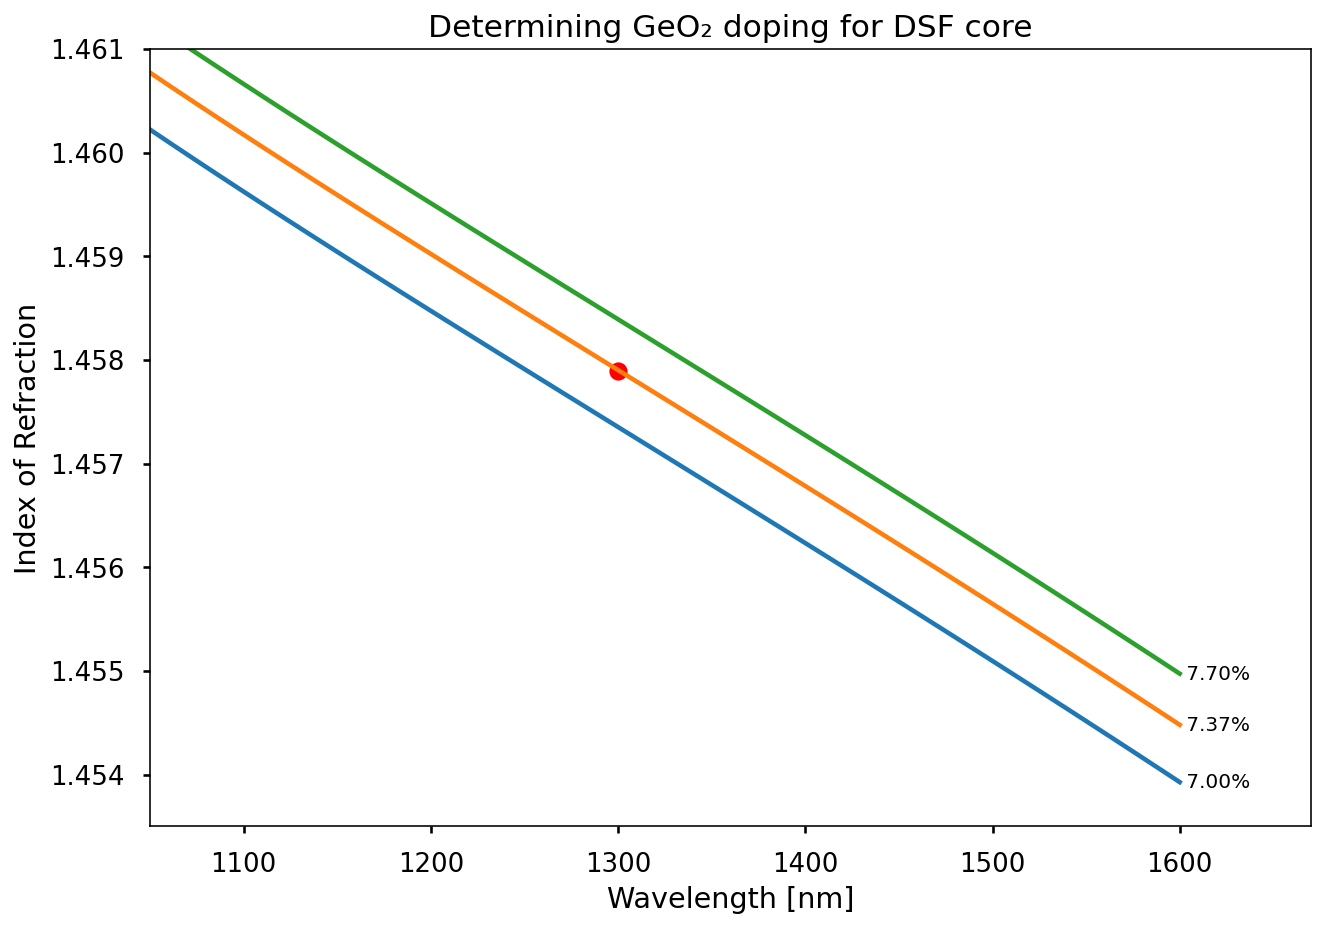

In [12]:
λ_pts=np.array([1300])*1e-9
n_pts = np.array([1.457893])
plt.plot(λ_pts*1e9, n_pts, 'or')

# Plot too much, too little, and just the right amount of GeO₂
λ0 = np.linspace(1000,1600,50)*1e-9
for x in [0.070,0.0737,0.077]:
    core = ofiber.doped_glass(x)
    n_core = ofiber.n(core,λ0)
    plt.plot(λ0*1e9,n_core)
    plt.text(1600, n_core[-1], " %.2f%%"%(100*x), va='center')

plt.ylim(1.4535,1.461)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Index of Refraction')
plt.xlim(1050,1670)
plt.title('Determining GeO₂ doping for DSF core')
plt.show()
   

### Replicate table 10.3

We can now calculate the index of refraction at the other two wavelengths and produced Table 10.3.  Note that this fiber has very close to zero dispersion for 1560nm and not 1523nm as suggested in the text (and table!).

Now show the total dispersion is zero at the desired wavelength 1560nm.

In [13]:
r_core=2.3e-6                                 # [m]
λ=np.array([1100,1300,1560])*1e-9  # [m]

core = ofiber.doped_glass(0.0735)
clad = ofiber.doped_glass(0)

n_core = ofiber.n(core,λ)
n_clad = ofiber.n(clad,λ)

NA = ofiber.numerical_aperture(n_core,n_clad)
V = ofiber.V_parameter(r_core, NA, λ)

vbpp = ofiber.V_d2bV_by_V(V,0)
dm, dw = ofiber.Dispersion(core, n_clad, r_core, λ)

dm *= 1e6
dw *= 1e6
dt = dm + dw


print("Ghatak Table 10.3")
print()
print("                  1100nm     1300nm  1560nm")
print("Delta             %.4f    %.4f    %.4f"%(Delta[0],Delta[1],Delta[2]))
print("V                 %.3f     %.3f     %.3f"%(V[0],V[1],V[2]))
print("V(bV)''           %.3f     %.3f     %.3f"%(vbpp[0],vbpp[1],vbpp[2]))
print("D_w (ps/km/nm)    %.2f    %.2f    %.2f"%(dw[0],dw[1],dw[2]))
print("D_m (ps/km/nm)   %.2f     %.2f     %.2f"%(dm[0],dm[1],dm[2]))
print("D_t (ps/km/nm)   %.2f    %.2f     %.2f"%(dt[0],dt[1],dt[2]))

Ghatak Table 10.3

                  1100nm     1300nm  1560nm
Delta             0.0027    0.0027    0.0027
V                 2.344     1.983     1.656
V(bV)''           0.224     0.477     0.843
D_w (ps/km/nm)    -7.34    -13.27    -19.64
D_m (ps/km/nm)   -25.81     -0.65     19.69
D_t (ps/km/nm)   -33.15    -13.91     0.05


## Dispersion Compensating Fibers

To match example 10.4, once again we need to determine the doping to reach n=1.476754 at 1300nm.

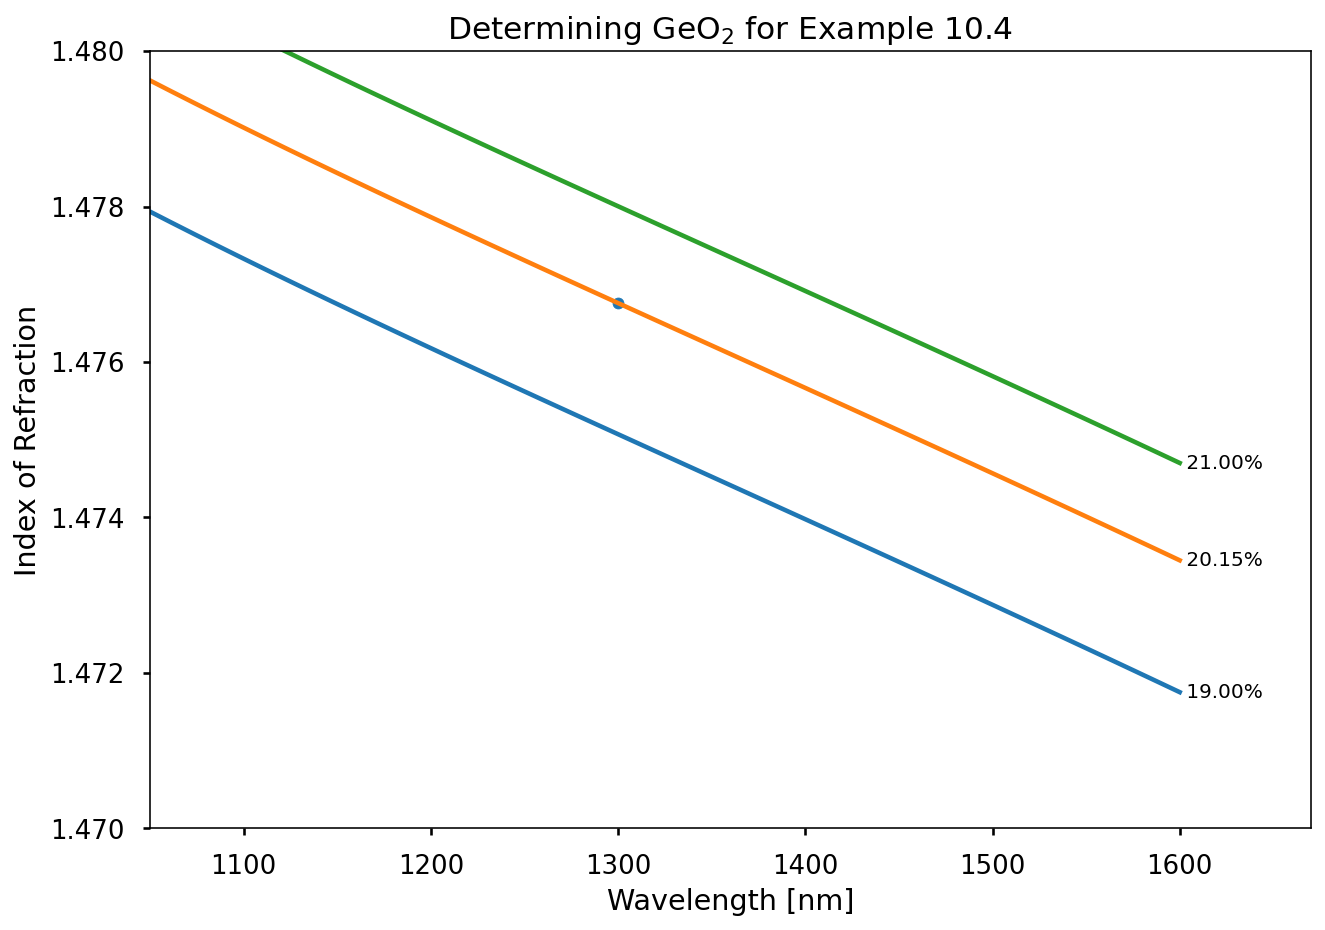

In [14]:
# estimation of doping of core for Ghatak Example 10.4

λ=np.array([1300])*1e-9
n = ofiber.n(glass,λ)
target = np.array([1.476754])
   
plt.scatter(λ*1e9,target,s=30)

lambda00 = np.linspace(1000,1600,50)*1e-9
for x in [0.19,0.2015,0.21]:
    glass = ofiber.doped_glass(x)
    n = ofiber.n(glass,lambda00)
    plt.plot(lambda00*1e9,n)
    plt.annotate(" %.2f%%"%(100*x),xy=(1600,n[-1]),va='center')

plt.ylim(1.47,1.48)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Index of Refraction')
plt.xlim(1050,1670)
plt.title('Determining GeO$_2$ for Example 10.4')
plt.show()
   

Now calculate the dispersion at each wavelength.  Despite getting the correct values for the relative refractive index $\Delta$ and $V$, the dispersion values are off by about a factor of two from those cited on page 191.  Don't really understand why. 

I suspect that the graph used a different doping concentration and that the value of $n_14 listed in equation 10.22 is wrong.

In [15]:
r_core=1.5e-6                                 # [m]
λ=np.array([1100,1300,1560])*1e-9  # [m]

core = ofiber.doped_glass(0.2015)
clad = ofiber.doped_glass(0.00)

n_core = ofiber.n(core,λ)
n_clad = ofiber.n(clad,λ)
Delta = (n_core**2-n_clad**2)/(2*n_core**2)

NA = ofiber.numerical_aperture(n_core,n_clad)
V = ofiber.V_parameter(r_core, NA, λ)
VV = 2783.6/λ*1e-9

dm = ofiber.Material_Dispersion(core,λ)* 1e6
dw = ofiber.Waveguide_Dispersion(n_core,n_clad,r_core,λ) * 1e6          
dt = dm+dw

print("                 1100nm     1300nm     1560nm")
print("n_core          %.5f    %.5f    %.5f"%(n_core[0],n_core[1],n_core[2]))
print("n_clad          %.5f    %.5f    %.5f"%(n_clad[0],n_clad[1],n_clad[2]))
print("Delta           %.5f    %.5f    %.5f"%(Delta[0],Delta[1],Delta[2]))
print()

print("V                 %.3f      %.3f      %.3f"%(V[0],V[1],V[2]))
print("2783.6/λ          %.3f      %.3f      %.3f"%(VV[0],VV[1],VV[2]))
print()

print("D_w (ps/km/nm)   %.2f     %.2f     %.2f"%(dw[0],dw[1],dw[2]))
print("D_m (ps/km/nm)   %.2f      %.2f      %.2f"%(dm[0],dm[1],dm[2]))
print("D_t (ps/km/nm)   %.2f     %.2f     %.2f"%(dt[0],dt[1],dt[2]))
print()
print("Which are about half the values given on page 191 of Ghatak ...")

                 1100nm     1300nm     1560nm
n_core          1.47901    1.47676    1.47390
n_clad          1.44920    1.44692    1.44390
Delta           0.01995    0.02000    0.02014

V                 2.531      2.141      1.787
2783.6/λ          2.531      2.141      1.784

D_w (ps/km/nm)   -11.98     -25.96     -42.20
D_m (ps/km/nm)   -33.24      -6.16      15.03
D_t (ps/km/nm)   -45.22     -32.12     -27.17

Which are about half the values given on page 191 of Ghatak ...


## Comparison of DCF, DSF, and CSF fiber dispersion

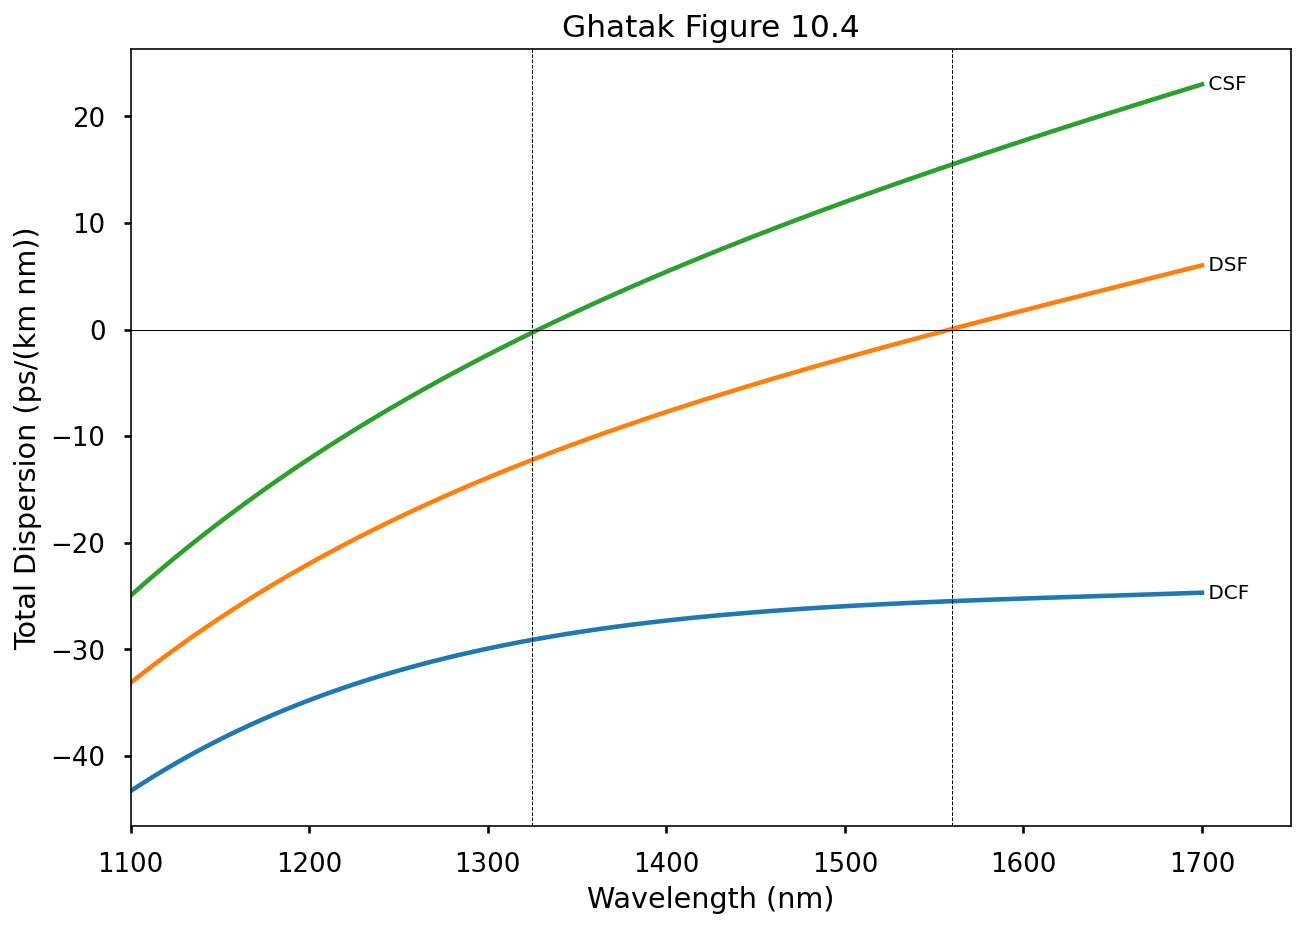

In [16]:
λ=np.linspace(1100,1700,100)*1e-9  # [m]

clad = ofiber.doped_glass(0.0)
n_clad = ofiber.n(clad,λ)

# Dispersion Compensating Fiber
r_core=1.5e-6                           # [m]
core = ofiber.doped_glass(0.2205)
dm, dw = ofiber.Dispersion(core, n_clad, r_core, λ)
dt = (dm + dw) * 1e6
plt.plot(λ*1e9,dt)
plt.text(1700, dt[-1], ' DCF', va='center')

# Dispersion Shifted Fiber
r_core=2.3e-6
core = ofiber.doped_glass(0.0735)
dm, dw = ofiber.Dispersion(core, n_clad, r_core, λ)
dt = (dm + dw) * 1e6
plt.plot(λ*1e9,dt)
plt.text(1700, dt[-1], ' DSF', va='center')

# Conventional Single-mode Fiber
r_core=4.1e-6
core = ofiber.doped_glass(0.026)
dm, dw = ofiber.Dispersion(core, n_clad, r_core, λ)
dt = (dm + dw) * 1e6
plt.plot(λ*1e9,dt)
plt.text(1700, dt[-1], ' CSF', va='center')

plt.axhline(0.0, color='black', lw=0.5)
plt.axvline(1325, color='black', lw=0.5, ls='--')
plt.axvline(1560, color='black', lw=0.5, ls='--')

plt.xlabel("Wavelength (nm)")
plt.ylabel("Total Dispersion (ps/(km nm))")
plt.title('Ghatak Figure 10.4')
plt.xlim(1100,1750)
plt.show()

## Single mode operation region

It depends on $\Delta$, the fiber radius, and the wavelength.  Figure 10.5

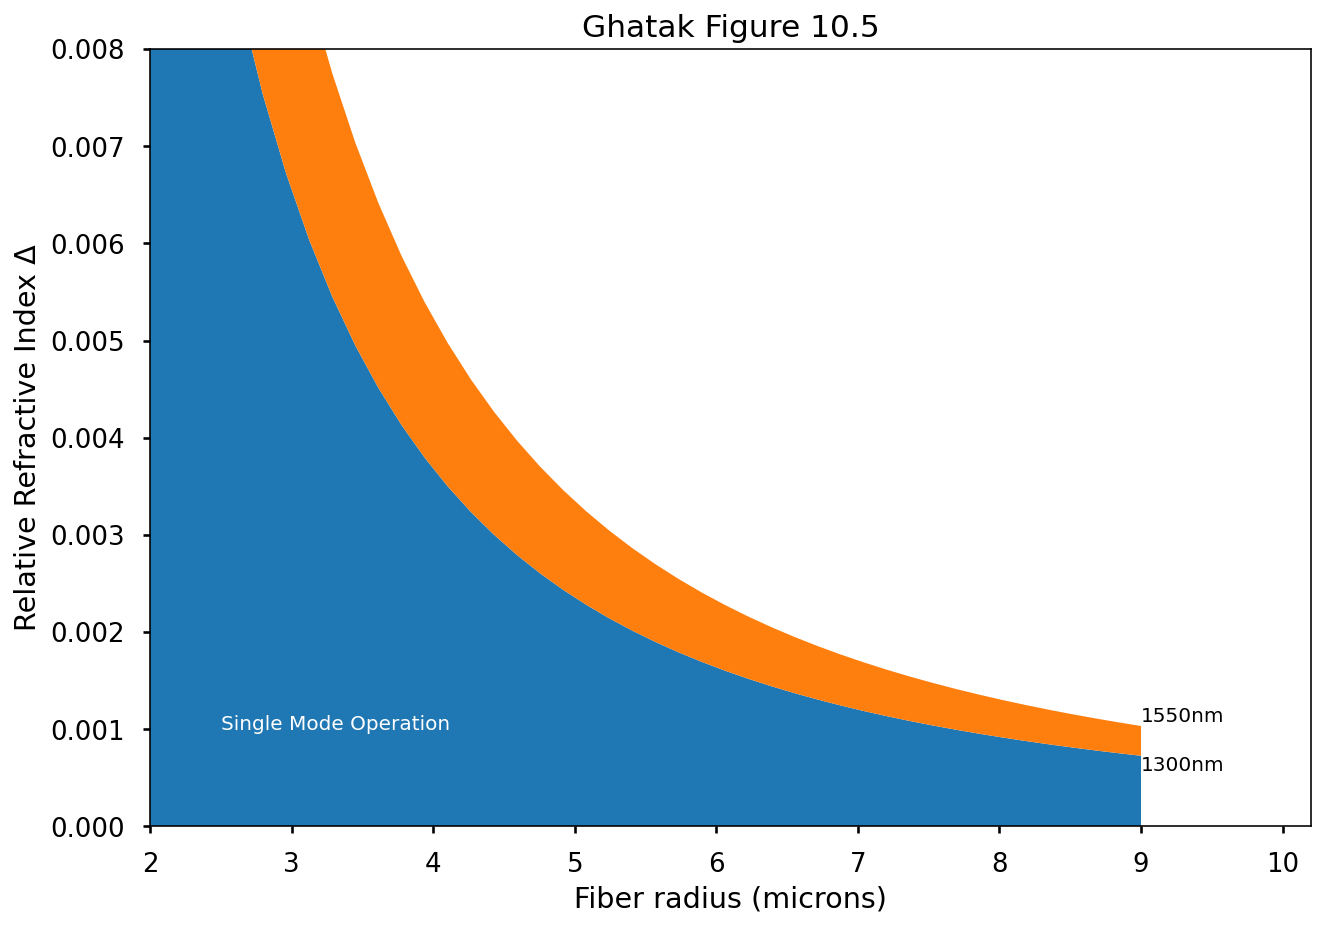

In [17]:
r_core = np.linspace(1,9,50)*1e-6

n_core = 1.45
Vc = 2.4048

Δ_1300 = 0.5*(Vc/2/np.pi/n_core * 1300e-9/r_core)**2
Δ_1550 = 0.5*(Vc/2/np.pi/n_core * 1550e-9/r_core)**2

plt.fill_between(r_core*1e6, 0, Δ_1300)
plt.text(9, Δ_1300[-1], '1300nm', va='top')

plt.fill_between(r_core*1e6, Δ_1300, Δ_1550)
plt.text(9, Δ_1550[-1], '1550nm', va='bottom')

plt.xlabel('Fiber radius (microns)')
plt.ylabel(r'Relative Refractive Index Δ')
plt.title('Ghatak Figure 10.5')
plt.ylim(0,0.008)
plt.xlim(2,10.2)
plt.text(2.5,0.001, 'Single Mode Operation',color='white')
plt.show()

## Petermann-2 spot size

The recommendation is that the Petermann-2 spot size for a single-mode fiber should be limited to 4.5 to 5 microns. This really restricts the possible values for core radius and $\Delta$ for single mode fibers.

### Influence of splicing offset on design

The $V$ parameter is
$$
V = \frac{2\pi r_\mathrm{core}}{\lambda_0}  \sqrt{n_\mathrm{core}^2 - n_\mathrm{clad}^2}
$$
or
$$
\Delta = {1\over2}\left( {V\lambda_0\over 2\pi r_\mathrm{core} n_\mathrm{core}}\right)^2
$$
Now if
$$
w_p = \alpha r_\mathrm{core}
$$
then
$$
\Delta = {1\over2}\left( {V\lambda_0\over 2\pi \alpha w_p n_1}\right)^2
$$

This graph shows possible values of Δ for $r_\mathrm{core}$ particular core radius and Petermann-2 spot size. 

The blue band shows the allowed values for the Petermann-2 spot size
according to the CCITT recommendations. (These are based on offset concerns during splicing, among other things.) 

Specifically, a single-mode fiber (to be used in a communication system) must have
$$
4.5\le w_p\le 5.0
$$

The graph below is for λ=1300nm.

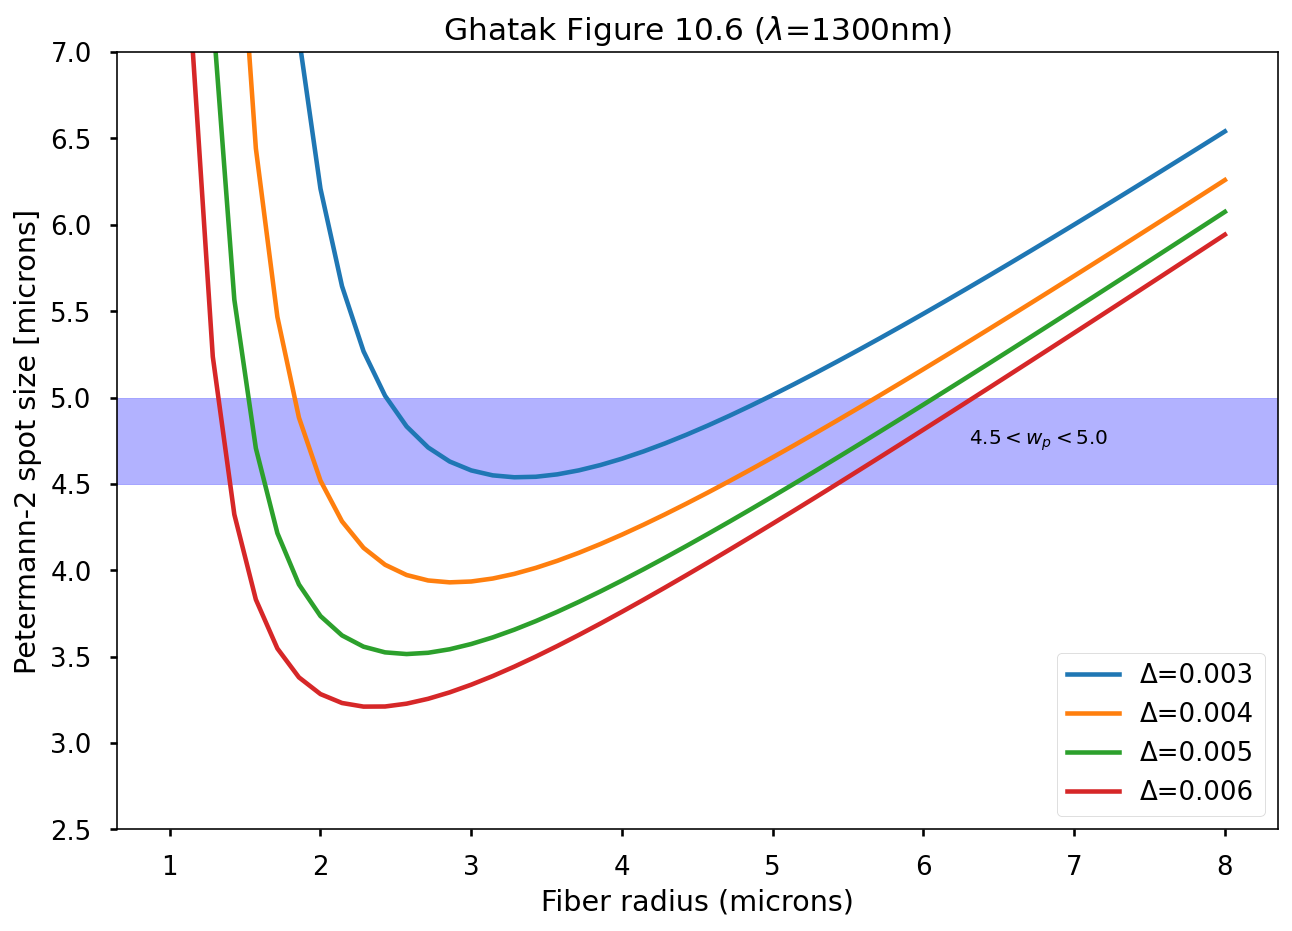

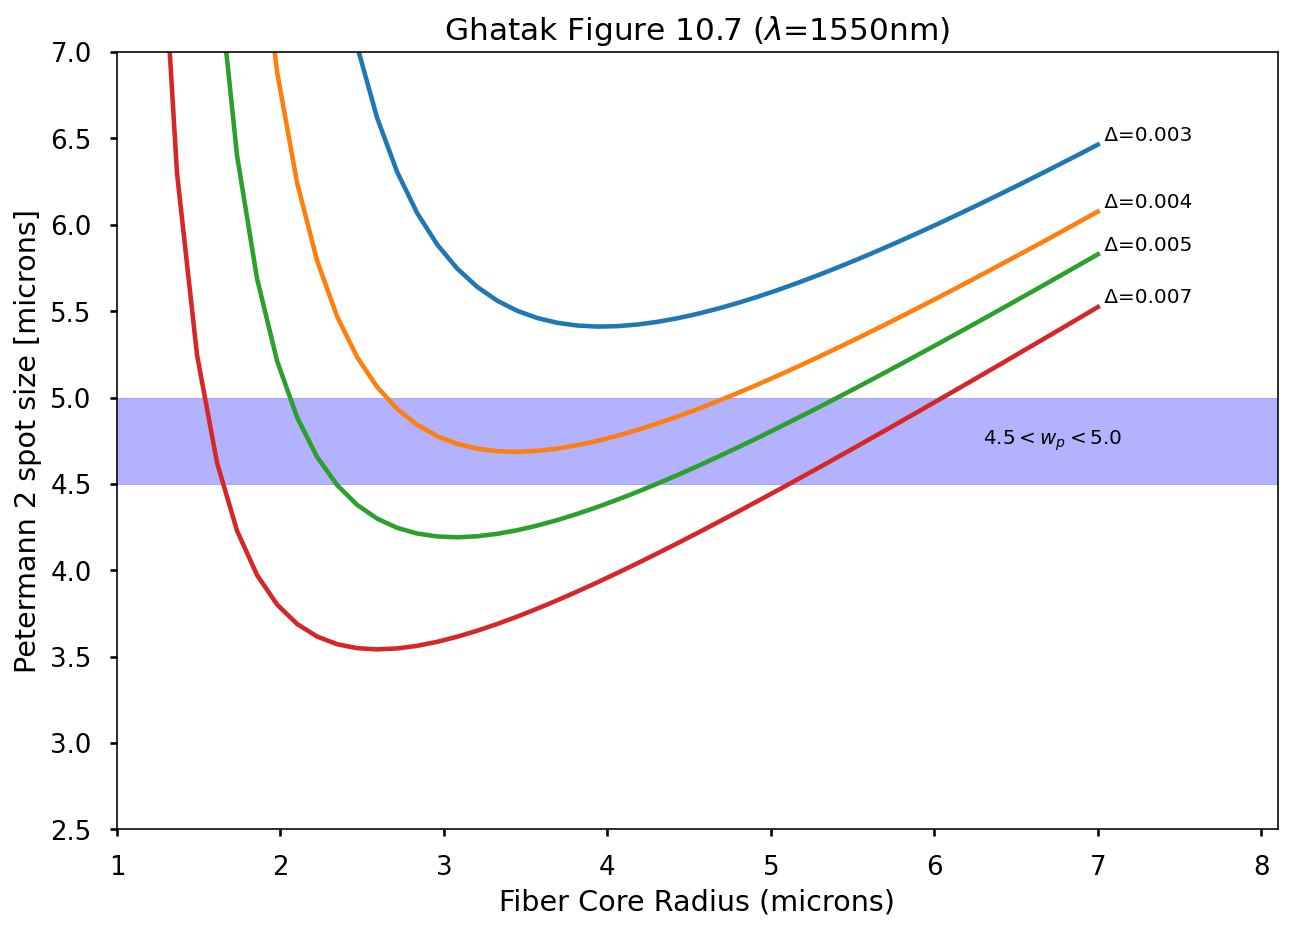

In [18]:
r_core=np.linspace(1,8,50)*1e-6

n_core=1.45
λ = 1300e-9

for i in range(3,7):
    Δ = i * 0.001
    V = (2*np.pi/λ) * r_core * n_core * np.sqrt(2*Δ)
    wp = ofiber.PetermannW(V)*r_core
    plt.plot(r_core*1e6,wp*1e6,label=r'Δ=%.3f'%Δ)

plt.xlabel('Fiber radius (microns)')
plt.ylabel('Petermann-2 spot size [microns]')
plt.title('Ghatak Figure 10.6 ($\lambda$=1300nm)')
plt.ylim(2.5,7)
plt.axhspan(4.5,5, color='blue', alpha=0.3)
plt.text(6.3, 4.75, r"$4.5< w_p < 5.0$", va='center')
plt.legend()
plt.show()

r_core=np.linspace(1,7,50)*1e-6

n_core=1.45

λ = 1550e-9

Δ= np.array([0.003,0.004,0.005,0.007])
for i, delta in enumerate(Δ):
    V = (2*np.pi*r_core/λ) * n_core * np.sqrt(2*delta)
    wp = ofiber.PetermannW(V)*r_core
    plt.plot(r_core*1e6,wp*1e6)
    plt.text(r_core[-1]*1e6,wp[-1]*1e6, ' Δ=%.3f'%delta, va='bottom')

plt.xlabel('Fiber Core Radius (microns)')
plt.ylabel('Petermann 2 spot size [microns]')
plt.title('Ghatak Figure 10.7 ($\lambda$=1550nm)')
plt.ylim(2.5,7)
plt.xlim(1,8.1)
plt.axhspan(4.5,5, color='blue', alpha=0.3)
plt.text(6.3, 4.75, r"$4.5< w_p < 5.0$", va='center')

plt.show()

## The influence of bending on fiber design

This a plot of losses for 100 turns of the fiber wound with a radius of 37.5 mm.  


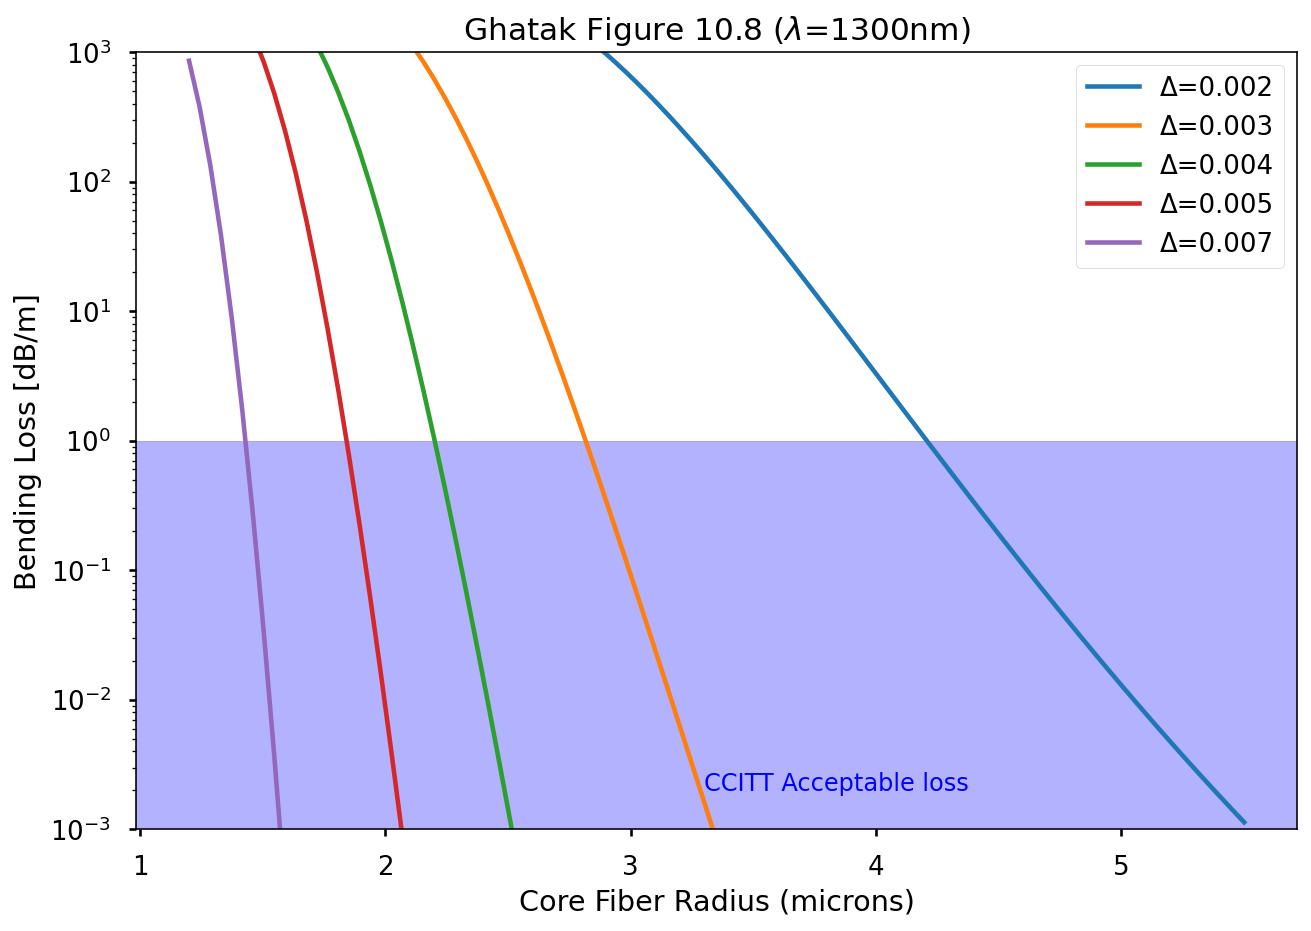

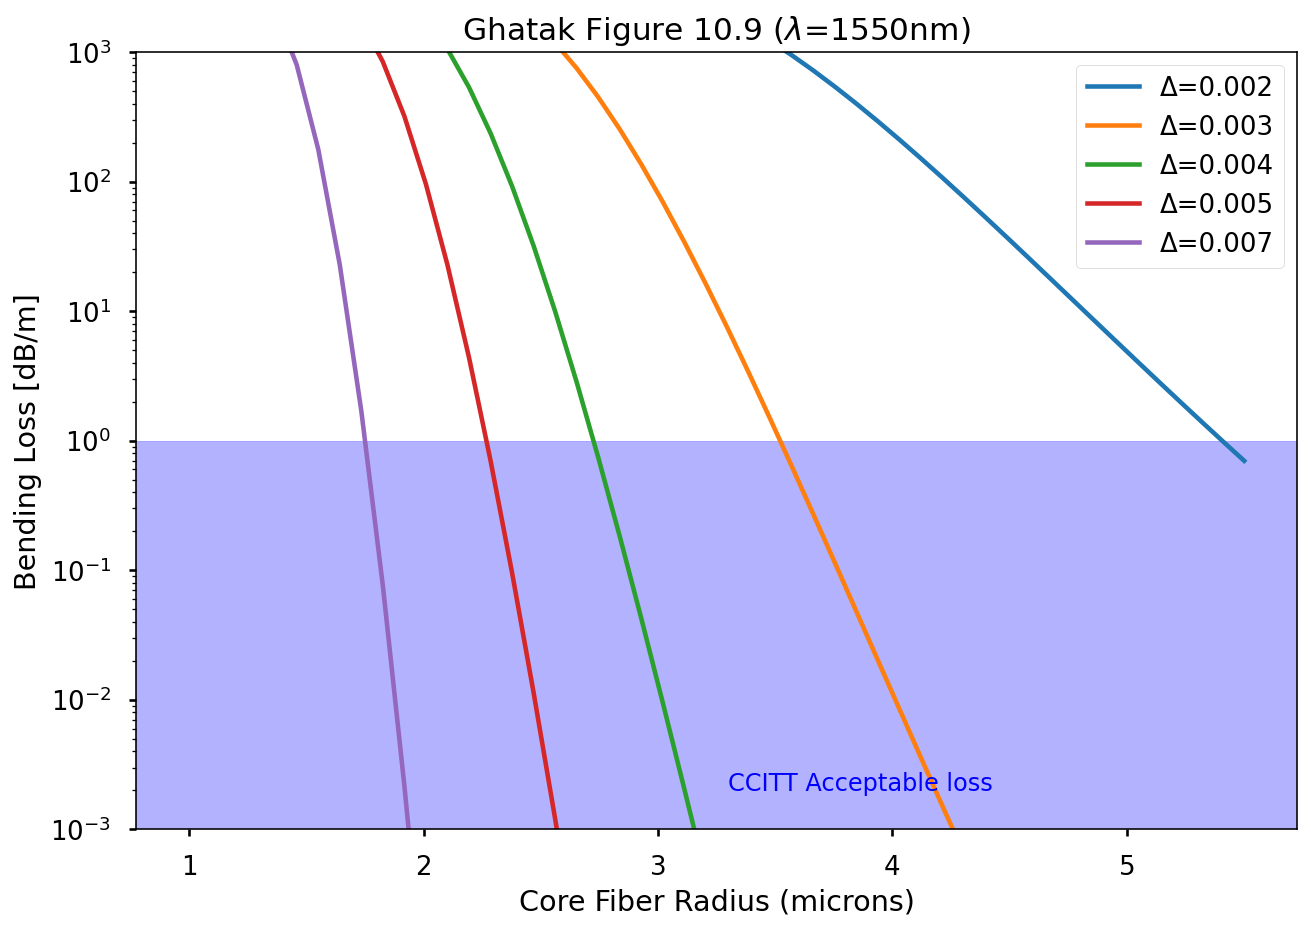

In [19]:
r_core=np.linspace(1.2,5.5,100)*1e-6

n_core=1.45
λ = 1300e-9     # [m]
Rc = 37.5e-3    # [m]

Δ= np.array([0.002, 0.003, 0.004, 0.005, 0.007])
plt.yscale('log')
for i, delta in enumerate(Δ):

    alpha = ofiber.bending_loss_db(n_core, delta, r_core, Rc, λ)
    plt.plot(r_core*1e6,alpha,label='Δ=%.3f'%delta)

plt.axhspan(1e-3,1,color='blue',alpha=0.3)
plt.text(3.3,0.002,"CCITT Acceptable loss", color='blue', fontsize=12)
plt.xlabel('Core Fiber Radius (microns)')
plt.ylabel('Bending Loss [dB/m]')
plt.title('Ghatak Figure 10.8 ($\lambda$=1300nm)')
plt.ylim(1e-3,1e3)
plt.legend()
plt.show()

r_core=np.linspace(1,5.5,50)*1e-6

n_core=1.45
λ = 1550e-9    # [m]
Rc = 3.75e-2         # 3.75cm

Δ= np.array([0.002, 0.003, 0.004, 0.005, 0.007])
plt.yscale('log')
for i, delta in enumerate(Δ):

    alpha = ofiber.bending_loss_db(n_core, delta, r_core, Rc, λ)
    plt.plot(r_core*1e6,alpha,label='Δ=%.3f'%delta)

plt.axhspan(1e-3,1,color='blue',alpha=0.3)
plt.text(3.3,0.002,"CCITT Acceptable loss", color='blue', fontsize=12)
plt.xlabel('Core Fiber Radius (microns)')
plt.ylabel('Bending Loss [dB/m]')
plt.title('Ghatak Figure 10.9 ($\lambda$=1550nm)')
plt.ylim(1e-3,1e3)
plt.legend(loc="upper right")
plt.show()